In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import torch#, time
import torch.nn as nn
device = torch.device("cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import OneHotEncoder

Resource: 
* https://bagheri365.github.io/blog/Graph-Convolutional-Networks-(GCNs)-from-Scratch/ (took only few lines)



* $A$ - adjacency matrix $(N_{nodes},N_{nodes})$
* $D$ - degree matrix $(N_{nodes},N_{nodes})$
* $H$ - feature matrix $(N_{nodes},N_{feat})$. row- a feature

$$ H = 
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 &  \dots & \vec{h}_n
\end{bmatrix}^T
$$
GCN layer is as follows (https://arxiv.org/pdf/1609.02907.pdf):
$$H^{l+1} = \sigma( D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} H^l W_h + \vec{b_h})$$
$$ \tilde A = A + I $$ 
$$ A_{full} = D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} $$ 

* shape $A_{full}$ - $(N_{nodes},N_{nodes})$


$A_{full}$ does agglomeration of features in $H^l$.
$$H_{agg}^l = A_{full}H^l$$
* shape $H_{agg}^l $ - $(N_{nodes},N_{feat})$
$$H^{l+1} = \sigma( H_{agg}^l W_h + \vec{b_h})$$
$W_h$ is a linear map that embeds rows of $H^l$ into latent vector (hidden state) of shape  `hs`.<br>
$W_h$ shape is $(N_{feat},N_{hs})$;
$\vec{b_h}$ is a bias of shape $(N_{hs})$

We can use pytorch torch.nn.Linear(), which solves 
$$y = x W^T + b$$
Where shapes of fields are:
* x - $(*, f_{in})$;
* $W^T$ - $(f_{in}, f_{out})$;
* b - $f_{out}$;
* y - $(*, f_{out})$

Which matches our problem.

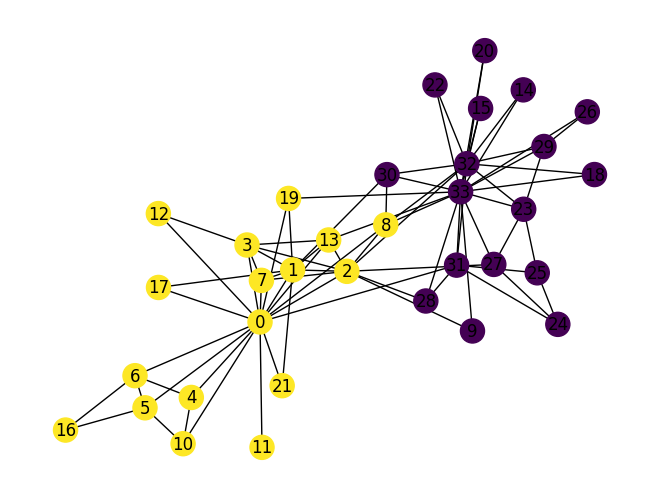

In [2]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
node_color = np.array([1 if c == 'Mr. Hi' else 0 for n,c in G.nodes(data='club')])
nx.draw(G, pos=pos, with_labels=True, node_color = node_color)

* Generate  $H_{agg}^{l = 0}$

In [3]:
A = nx.adjacency_matrix(G, weight=None)
A_tilde = A + np.eye(*A.shape);display(A_tilde)
node_degrees = [degree for node, degree in G.degree]
D_inv = np.diag(1/np.sqrt(node_degrees))
A_full = D_inv @ A_tilde @ D_inv; A_full.shape
L = torch.tensor(nx.laplacian_matrix(G, weight=None).todense(), dtype=torch.float);L

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

tensor([[16., -1., -1.,  ..., -1.,  0.,  0.],
        [-1.,  9., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., 10.,  ...,  0., -1.,  0.],
        ...,
        [-1.,  0.,  0.,  ...,  6., -1., -1.],
        [ 0.,  0., -1.,  ..., -1., 12., -1.],
        [ 0.,  0.,  0.,  ..., -1., -1., 17.]])

Features are one-hot-encoded node IDs of length 34.

$$ H = 
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 &  \dots & \vec{h}_n
\end{bmatrix}^T
$$

So just rows of identity matrix N nodes by N features.
***

GCN will do aggregation on in two steps:
1. aggregate initial node IDs one-hot index (*, 34) and map embeddings to (*, 4)
2. aggregate embeddings and map them to (*,2)

Final embeddings should represent one-hot vector which tags 'club'- ether 0: 'Mr. Hi' or 1: 'Officer'

Loss is two-fold:
1. suprevised loss on masked club membership
2. Frobenius norm regularization
***

In [4]:
N_FEATURES, N_NODES = A.shape
HIDDEN = 4
OUT_FEATURES = 2

class net(nn.Module):
    def __init__(self, H0, A):
        super(net, self).__init__()
        self.H0     = torch.tensor(H0, dtype=torch.float, requires_grad=False, device=device)
        self.A      = torch.tensor(A,  dtype=torch.float, requires_grad=False, device=device)
        self.l1     = nn.Linear(N_FEATURES, HIDDEN     , bias=False, device=device)
        self.l2     = nn.Linear(HIDDEN, OUT_FEATURES   , bias=False, device=device)
        self.activation = nn.ReLU()
        self.activation2 = nn.Softmax(dim = 1)

    def forward(self):
        # layer 1
        y = self.A @ self.H0
        y = self.l1(y)
        y = self.activation(y)
        # layer 2
        y = self.A @ y
        y = self.l2(y)
        y = self.activation2(y)
        #y = torch.argmax(y, dim=1)
        return y
    
H_0 = np.eye(*A.shape)

model = net(H_0, A_full)
model
test = model();test

tensor([[0.4939, 0.5061],
        [0.4950, 0.5050],
        [0.5034, 0.4966],
        [0.5008, 0.4992],
        [0.5008, 0.4992],
        [0.5013, 0.4987],
        [0.5012, 0.4988],
        [0.5002, 0.4998],
        [0.4954, 0.5046],
        [0.5025, 0.4975],
        [0.5004, 0.4996],
        [0.4855, 0.5145],
        [0.5014, 0.4986],
        [0.5003, 0.4997],
        [0.4964, 0.5036],
        [0.4960, 0.5040],
        [0.5015, 0.4985],
        [0.4938, 0.5062],
        [0.4979, 0.5021],
        [0.4996, 0.5004],
        [0.4941, 0.5059],
        [0.4984, 0.5016],
        [0.4987, 0.5013],
        [0.5024, 0.4976],
        [0.5055, 0.4945],
        [0.5019, 0.4981],
        [0.5022, 0.4978],
        [0.5050, 0.4950],
        [0.5031, 0.4969],
        [0.5007, 0.4993],
        [0.4940, 0.5060],
        [0.5027, 0.4973],
        [0.4930, 0.5070],
        [0.4982, 0.5018]], grad_fn=<SoftmaxBackward0>)

In [5]:
Y_train = OneHotEncoder(categories='auto').fit_transform(node_color.reshape(-1, 1))
Y_train = torch.tensor(Y_train.todense());Y_train.shape
mask = torch.zeros(N_NODES, 1, requires_grad=False, device=device)
mask[[0,33]] = 1
Y_train

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=torch.float64)

In [6]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, Z, targets, mask):
        Z_masked, tar_masked = Z*mask, targets*mask
        #ce_loss = nn.CrossEntropyLoss(reduction='none')(inp_masked, tar_masked)  # Compute CrossEntropyLoss element-wise
        return -torch.sum(tar_masked * torch.log(Z_masked+0.0001))
    
with torch.no_grad():
    loss = MaskedCrossEntropyLoss()

    print(loss(test, Y_train, mask))

tensor(1.3774, dtype=torch.float64)


In [7]:
optimizer  = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = MaskedCrossEntropyLoss()
def train():
    model.train()
    optimizer.zero_grad()
    Z = model()
    loss1 = criterion(Z = Z, targets = Y_train, mask=mask)
    loss2 = torch.norm(torch.transpose(Z,0,1) @ L @ Z, p = 'fro')
    alpha = 0.01
    loss = loss1 + alpha*loss2
    loss.backward()
    optimizer.step()
    return loss, Z

train()

(tensor(1.3774, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[0.4939, 0.5061],
         [0.4950, 0.5050],
         [0.5034, 0.4966],
         [0.5008, 0.4992],
         [0.5008, 0.4992],
         [0.5013, 0.4987],
         [0.5012, 0.4988],
         [0.5002, 0.4998],
         [0.4954, 0.5046],
         [0.5025, 0.4975],
         [0.5004, 0.4996],
         [0.4855, 0.5145],
         [0.5014, 0.4986],
         [0.5003, 0.4997],
         [0.4964, 0.5036],
         [0.4960, 0.5040],
         [0.5015, 0.4985],
         [0.4938, 0.5062],
         [0.4979, 0.5021],
         [0.4996, 0.5004],
         [0.4941, 0.5059],
         [0.4984, 0.5016],
         [0.4987, 0.5013],
         [0.5024, 0.4976],
         [0.5055, 0.4945],
         [0.5019, 0.4981],
         [0.5022, 0.4978],
         [0.5050, 0.4950],
         [0.5031, 0.4969],
         [0.5007, 0.4993],
         [0.4940, 0.5060],
         [0.5027, 0.4973],
         [0.4930, 0.5070],
         [0.4982, 0.5018]], grad_fn=<SoftmaxBac

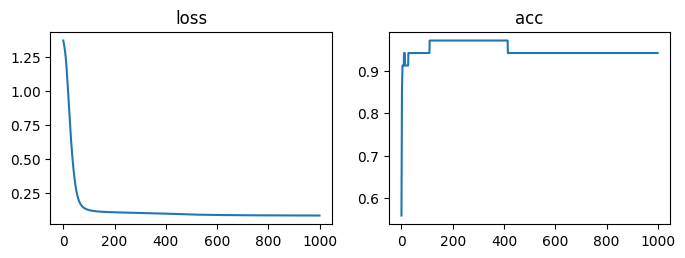

In [8]:
ITERS = 1000
fig, ax = plt.subplots(1,2, figsize = (8,2.5))
loss = torch.zeros(ITERS)
acc = torch.zeros(ITERS)
for i in range(ITERS):
    l,Z = train()
    loss[i] = l
    zz = torch.argmax(Z, dim= 1)    #pick highest prob for each node
    # compare to club marking abs diff. mean shows percentage of failed classifications
    acc[i] = 1 - torch.mean(torch.abs(zz-torch.tensor(node_color, dtype=torch.float)))

ax[0].plot(loss.cpu().detach().numpy())
ax[1].plot(acc.cpu().detach().numpy())
ax[1].set_title('acc')
ax[0].set_title('loss');

In [9]:
with torch.no_grad():
  Z = model()
  zz = torch.argmax(Z, dim= 1)
  print(torch.abs(zz-torch.tensor(node_color, dtype=torch.float)))
  print(1- torch.mean(torch.abs(zz-torch.tensor(node_color, dtype=torch.float))))


tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.9412)
